In [1]:
# Extra Setup for Colaboratory Environment

#!pip install cmake
#!pip install dlib

#from google.colab import files
#uploaded = files.upload() 

#!7za e colaboratory_dependencies.7z
#!7za x frontalization_models.7z
#!7za x dlib_models.7z

In [2]:
'''
Libraries, etc.
'''
import os
import sys
import cv2
import numpy as np 
import scipy as sp
import pandas as pd 
import seaborn as sns
from math import sqrt
import scipy.io as io
import tensorflow as tf 
from pathlib import Path
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix

from keras import backend as K
from keras.utils import np_utils
#from keras.models import Sequential
from keras.utils import np_utils as npu
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#from keras.layers import Convolution2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten

import frontalize
import check_resources as check
import camera_calibration as calib
import facial_feature_detector as feature_detection

from models import get_model1, get_model2, get_model3, get_model4

#this_path = os.path.dirname(os.path.abspath(__file__)) 
this_path = str(Path().resolve()) # for Colaboratory

Using TensorFlow backend.


In [3]:
'''
Constants, Hyperparameters, etc.
'''
BATCH_SIZE = 128
NUM_EPOCHS = 40
input_file = 'fer2013.csv'
filepath = 'Model.{epoch:02d}-{val_acc:.4f}.hdf5'

model1_acc_file = "acc_model1_t2.png"
model2_acc_file = "acc_model2_t2.png"
model3_acc_file = "acc_model3_t2.png"
model4_acc_file = "acc_model4_t2.png"
acc_file = model1_acc_file

model1_loss_file = "loss_model1_t2.png"
model2_loss_file = "loss_model2_t2.png"
model3_loss_file = "loss_model3_t2.png"
model4_loss_file = "loss_model4_t2.png"
loss_file = model1_loss_file

model1_cm_file = "cm_model1_t2.png"
model2_cm_file = "cm_model2_t2.png"
model3_cm_file = "cm_model3_t2.png"
model4_cm_file = "cm_model4_t2.png"
cm_file = model1_cm_file

emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
num_classes = len(emotion_labels)

In [4]:
'''
Load & Parse Data into Training/Test Labels & Images
'''
data = pd.read_csv(input_file)
data.head()

# get data and labels
train_set = data[(data.Usage == 'Training')]
validation_set = data[(data.Usage == 'PublicTest')]
test_set = data[(data.Usage == 'PrivateTest')]

# greyscale so depth 1
depth = 1
height = int(sqrt(len(data.pixels[0].split())))
width = height

# from pandas to np array
X_train = np.array(list(map(str.split, train_set.pixels)), np.uint8)
X_validation = np.array(list(map(str.split, validation_set.pixels)), np.uint8)
X_test = np.array(list(map(str.split, test_set.pixels)), np.uint8)

# reshape data
num_train = X_train.shape[0]
num_validation = X_validation.shape[0]
num_test = X_test.shape[0]

X_train = X_train.reshape(num_train, width, height, depth)
X_validation = X_validation.reshape(num_validation, width, height, depth)
X_test = X_test.reshape(num_test, width, height, depth)

y_train = train_set.emotion
y_validation = validation_set.emotion
y_test = test_set.emotion

y_train = np_utils.to_categorical(y_train, num_classes)
y_validation = np_utils.to_categorical(y_validation, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# print shapes
print('X_training: ', X_train.shape)
print('X_validation: ', X_validation.shape)
print('X_test: ', X_test.shape)
print( )
print('y_training: ', y_train.shape)
print('y_validation: ', y_validation.shape)
print('y_test: ', y_test.shape)

X_training:  (28709, 48, 48, 1)
X_validation:  (3589, 48, 48, 1)
X_test:  (3589, 48, 48, 1)

y_training:  (28709, 7)
y_validation:  (3589, 7)
y_test:  (3589, 7)


In [5]:
'''
Frontalization Function
'''
def myfrontalize(X, limit=0):
  count = 0

  if (limit == 0):
    limit = X.shape[0]
    
  print("Total Images: ", limit)
    
  # check for dlib saved weights for face landmark detection
  # if it fails, dowload and extract it manually from
  # http://sourceforge.net/projects/dclib/files/dlib/v18.10/shape_predictor_68_face_landmarks.dat.bz2
  check.check_dlib_landmark_weights()
    
  # load detections performed by dlib library on 3D model and Reference Image
  model3D = frontalize.ThreeD_Model(this_path + "/frontalization_models/model3Ddlib.mat", 'model_dlib')
  
  # load mask to exclude eyes from symmetry
  eyemask = np.asarray(io.loadmat('frontalization_models/eyemask.mat')['eyemask'])
        
  for i in range(0, limit):
    print("\r", end='')
    print("Images Completed: {0}".format(i), end='', flush=True)

    # cast img to type int for cv2
    img = X[i, :, :, 0].astype(np.uint8)
    
    # create a color version for frontalizer stuffs
    c_img = np.copy(img)
    c_img = cv2.cvtColor(c_img, cv2.COLOR_GRAY2BGR)    
    
    # extract landmarks from the query image
    # list containing a 2D array with points (x, y) for each face detected in the query image
    lmarks = feature_detection.get_landmarks(c_img)
    if type(lmarks) is np.ndarray:
      
      # perform camera calibration according to the first face detected
      proj_matrix, camera_matrix, rmat, tvec = calib.estimate_camera(model3D, lmarks[0])
      
      # perform frontalization and convert result to grayscale
      frontal_raw, frontal_sym = frontalize.frontalize(c_img, proj_matrix, model3D.ref_U, eyemask)
      temp = cv2.cvtColor(frontal_raw, cv2.COLOR_BGR2GRAY)
    
      # find nonzero bbox and crop image to remove uncessesary black space from edges           
      temp_mask = cv2.findNonZero(temp)     
      t_x, t_y, t_w, t_h = cv2.boundingRect(temp_mask)
      t_bbox = temp[t_y:t_y+t_h, t_x:t_x+t_w]

      # resize the cropped image to the appropriate dimensions for network
      t_bbox = cv2.resize(t_bbox, dsize=(48, 48))  
      t_bbox = np.resize(t_bbox, (48, 48, 1))   
      X[i] = t_bbox.astype(np.float32)
    
      plt.show()
      count += 1
      
  print( )
  print('{} images out of {} were frontalized.'.format(count, limit))

Testing myfrontalize function
Total Images:  5
Images Completed: 4
4 images out of 5 were frontalized.
Total Images:  5
Images Completed: 4
4 images out of 5 were frontalized.
Total Images:  5
Images Completed: 4
3 images out of 5 were frontalized.
Original Images


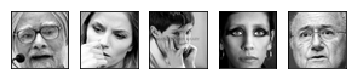

Original w/ Linear Transform to normalize pixel values


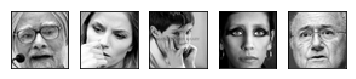

Normalized w/ Contrast Limited Adaptive Histogram Equalization


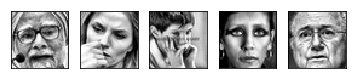

Frontalized, Cropped, and Resized


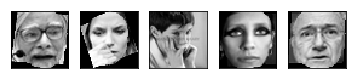

In [6]:
'''
Histogram Equalization - Not defined as method, because 
train has a special case to catch and delete harmful inputs
'''
clahe = cv2.createCLAHE(clipLimit=3.235, tileGridSize=(5,5))

# original image set
X_train1 = X_train.copy().astype(np.uint8)
X_val1 = X_validation.copy().astype(np.uint8)
X_test1 = X_test.copy().astype(np.uint8)

# linear histogram equalization set
X_train2 = X_train1.copy() 
X_val2 = X_val1.copy()
X_test2 = X_test1.copy()

# clahe set
X_train3 = X_train1.copy()
X_val3 = X_val1.copy()
X_test3 = X_test1.copy()

# frontalized set
X_train4 = X_train1.copy()
X_val4 = X_val1.copy()
X_test4 = X_test1.copy()

# histogram equalization
i = 0
while (i < num_train):
  tMax = X_train1[i].max()
  tMin = X_train1[i].min()  

  if (tMax > tMin):
    tRatio = 255 / (tMax - tMin)
    X_train2[i] = np.multiply((X_train1[i] - tMin), tRatio)
    X_train3[i] = clahe.apply(X_train2[i])[:,:,np.newaxis]
    i += 1
    
  # Delete harmful training examples from X_train
  else:
    X_train1 = np.delete(X_train1, (i), axis=0)
    X_train2 = np.delete(X_train2, (i), axis=0)
    X_train3 = np.delete(X_train3, (i), axis=0)
    X_train4 = np.delete(X_train4, (i), axis=0)
    y_train = np.delete(y_train, (i), axis=0)
    num_train -= 1
  
i = 0
while (i < num_validation):
  tMax = X_val1[i].max()
  tMin = X_val1[i].min()

  if (tMax > tMin):
    tRatio = 255 / (tMax - tMin)
    X_val2[i] = np.multiply((X_val1[i] - tMin), tRatio).round()
    
  # Shouldn't delete validation data... skip so we don't divide by 0
  else:
    X_val2[i] = X_val1[i]

  X_val3[i] = clahe.apply(X_val2[i])[:,:,np.newaxis]
  i += 1

i = 0
while (i < num_test):
  tMax = X_test1[i].max()
  tMin = X_test1[i].min()

  if (tMax > tMin):
    tRatio = 255 / (tMax - tMin)
    X_test2[i] = np.multiply((X_test1[i] - tMin), tRatio).round()
    
  # Shouldn't delete test data... skip so we don't divide by 0
  else:
    X_test2[i] = X_test1[i]
    
  X_test3[i] = clahe.apply(X_test2[i])[:,:,np.newaxis]
  i += 1
  
# test/demo frontalization
print('Testing myfrontalize function')
myfrontalize(X_train4, 5)
myfrontalize(X_val4, 5)
myfrontalize(X_test4, 5)

# apply frontalization
#print("Attempting to frontalize image data...")
#myfrontalize(X_train4, num_train)
#np.save('X_train_frontalized', X_train4)

#myfrontalize(X_val4, num_validation)
#np.save('X_val_frontalized', X_val4)

#myfrontalize(X_test4, num_test)
#np.save('X_test_frontalized', X_test4)

X_train4 = np.load('X_train_frontalized.npy')
X_val4 = np.load('X_val_frontalized.npy')
X_test4 = np.load('X_test_frontalized.npy')


# print examples from each set
print('Original Images')
for x in range(1,6):
    plt.subplot(1, 5, x)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train1[x,:,:,0], cmap='gray') 
plt.show()

print('Original w/ Linear Transform to normalize pixel values')
for x in range(1,6):
    plt.subplot(1, 5, x)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train2[x,:,:,0], cmap='gray')   
plt.show()

print('Normalized w/ Contrast Limited Adaptive Histogram Equalization')
for x in range(1,6):
    plt.subplot(1, 5, x)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train3[x,:,:,0], cmap='gray')    
plt.show() 

print('Frontalized, Cropped, and Resized')
for x in range(1,6):
  plt.subplot(1, 5, x)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X_train4[x, :, :, 0], cmap='gray') 
    
plt.show()

In [7]:
'''
Metric(s)
'''

# metric to balance precision and recall
def fbeta(y_true, y_pred, threshold_shift=0):
  beta = 1

  # just in case of hipster activation at the final layer
  y_pred = K.clip(y_pred, 0, 1)

  # shifting the prediction threshold from .5 if needed
  y_pred_bin = K.round(y_pred + threshold_shift)

  tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
  fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
  fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

  precision = tp / (tp + fp)
  recall = tp / (tp + fn)

  beta_squared = beta ** 2
  return K.mean((beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))


In [8]:
'''
Prepare Model for Training
'''
# assign the desired model from above
model1 = get_model1()
model2 = get_model2()
model3 = get_model3()
model4 = get_model4()

model1.summary()
model2.summary()
model3.summary()
model4.summary()

num_train = len(X_train)

# assign X to the desired image set(s) from above
X_train = X_train1.copy().astype(np.float32)
X_validation = X_val1.copy().astype(np.float32)
X_test = X_test1.copy().astype(np.float32)

print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

# reshape X matrices to the dimensions expected by the network
#X_train = X_train.reshape(num_train, width, height, depth)
#X_validation = X_validation.reshape(num_validation, width, height, depth)
#X_test = X_test.reshape(num_test, width, height, depth)

# augment and fit data
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0,
    zoom_range=0.0,
    horizontal_flip=True,
    vertical_flip=False)
datagen.fit(X_train)
datagen.fit(X_validation)

# to be applied during training
checkpointer = ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, 
    save_best_only=False, mode='auto')
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, 
    patience=10, verbose=0, mode='auto', 
    min_delta=0.0001, cooldown=0, min_lr=0)
early_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, 
    verbose=0, mode='auto')

# prepare model to train
model1.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=[fbeta, 'accuracy'])

model2.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=[fbeta, 'accuracy'])

model3.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=[fbeta, 'accuracy'])

model4.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=[fbeta, 'accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 128)       512       
__________

In [9]:
'''
Training
'''
train_flow = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_flow = datagen.flow(X_validation, y_validation)

history1 = model1.fit_generator(
    train_flow,
    steps_per_epoch= num_train / BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_data=validation_flow,
    validation_steps=num_validation / BATCH_SIZE,
    callbacks=[checkpointer, reduce_lr, checkpointer]
)

history2 = model2.fit_generator(
    train_flow,
    steps_per_epoch= num_train / BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_data=validation_flow,
    validation_steps=num_validation / BATCH_SIZE,
    callbacks=[checkpointer, reduce_lr, checkpointer]
)

history3 = model3.fit_generator(
    train_flow,
    steps_per_epoch= num_train / BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_data=validation_flow,
    validation_steps=num_validation / BATCH_SIZE,
    callbacks=[checkpointer, reduce_lr, checkpointer]
)

history4 = model4.fit_generator(
    train_flow,
    steps_per_epoch= num_train / BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_data=validation_flow,
    validation_steps=num_validation / BATCH_SIZE,
    callbacks=[checkpointer, reduce_lr, checkpointer]
)

Epoch 1/40
225/224 [==============================] - 12s 54ms/step - loss: 1.7658 - fbeta: 0.1122 - acc: 0.3207 - val_loss: 1.6045 - val_fbeta: 0.1616 - val_acc: 0.3782

Epoch 00001: saving model to Model.01-0.3782.hdf5

Epoch 00001: saving model to Model.01-0.3782.hdf5
Epoch 2/40
225/224 [==============================] - 8s 34ms/step - loss: 1.4442 - fbeta: 0.2365 - acc: 0.4460 - val_loss: 1.4761 - val_fbeta: 0.2414 - val_acc: 0.4450

Epoch 00002: saving model to Model.02-0.4450.hdf5

Epoch 00002: saving model to Model.02-0.4450.hdf5
Epoch 3/40
225/224 [==============================] - 8s 34ms/step - loss: 1.2981 - fbeta: 0.2960 - acc: 0.4999 - val_loss: 1.3113 - val_fbeta: 0.3675 - val_acc: 0.5119

Epoch 00003: saving model to Model.03-0.5119.hdf5

Epoch 00003: saving model to Model.03-0.5119.hdf5
Epoch 4/40
225/224 [==============================] - 8s 34ms/step - loss: 1.2242 - fbeta: 0.3340 - acc: 0.5310 - val_loss: 1.2760 - val_fbeta: 0.3385 - val_acc: 0.5205

Epoch 00004: sav

225/224 [==============================] - 8s 34ms/step - loss: 0.6024 - fbeta: 0.7098 - acc: 0.7765 - val_loss: 1.0315 - val_fbeta: 0.5873 - val_acc: 0.6498

Epoch 00031: saving model to Model.31-0.6498.hdf5

Epoch 00031: saving model to Model.31-0.6498.hdf5
Epoch 32/40
225/224 [==============================] - 8s 35ms/step - loss: 0.5927 - fbeta: 0.7127 - acc: 0.7787 - val_loss: 1.0051 - val_fbeta: 0.5827 - val_acc: 0.6504

Epoch 00032: saving model to Model.32-0.6504.hdf5

Epoch 00032: saving model to Model.32-0.6504.hdf5
Epoch 33/40
225/224 [==============================] - 8s 34ms/step - loss: 0.5923 - fbeta: 0.7198 - acc: 0.7806 - val_loss: 0.9872 - val_fbeta: 0.6185 - val_acc: 0.6864

Epoch 00033: saving model to Model.33-0.6864.hdf5

Epoch 00033: saving model to Model.33-0.6864.hdf5
Epoch 34/40
225/224 [==============================] - 8s 34ms/step - loss: 0.5778 - fbeta: 0.7256 - acc: 0.7859 - val_loss: 1.0482 - val_fbeta: 0.5636 - val_acc: 0.6325

Epoch 00034: saving model

225/224 [==============================] - 9s 42ms/step - loss: 0.7628 - fbeta: 0.6236 - acc: 0.7146 - val_loss: 1.1819 - val_fbeta: 0.4849 - val_acc: 0.5679

Epoch 00021: saving model to Model.21-0.5679.hdf5

Epoch 00021: saving model to Model.21-0.5679.hdf5
Epoch 22/40
225/224 [==============================] - 9s 41ms/step - loss: 0.7434 - fbeta: 0.6402 - acc: 0.7232 - val_loss: 1.1174 - val_fbeta: 0.5313 - val_acc: 0.5948

Epoch 00022: saving model to Model.22-0.5948.hdf5

Epoch 00022: saving model to Model.22-0.5948.hdf5
Epoch 23/40
225/224 [==============================] - 9s 41ms/step - loss: 0.7259 - fbeta: 0.6472 - acc: 0.7283 - val_loss: 1.0880 - val_fbeta: 0.5356 - val_acc: 0.6121

Epoch 00023: saving model to Model.23-0.6121.hdf5

Epoch 00023: saving model to Model.23-0.6121.hdf5
Epoch 24/40
225/224 [==============================] - 9s 42ms/step - loss: 0.7073 - fbeta: 0.6603 - acc: 0.7363 - val_loss: 1.1147 - val_fbeta: 0.4961 - val_acc: 0.5838

Epoch 00024: saving model

225/224 [==============================] - 14s 62ms/step - loss: 1.0899 - fbeta: 0.4187 - acc: 0.5840 - val_loss: 1.2292 - val_fbeta: 0.4267 - val_acc: 0.5431

Epoch 00011: saving model to Model.11-0.5431.hdf5

Epoch 00011: saving model to Model.11-0.5431.hdf5
Epoch 12/40
225/224 [==============================] - 14s 63ms/step - loss: 1.0631 - fbeta: 0.4341 - acc: 0.5986 - val_loss: 1.0753 - val_fbeta: 0.4606 - val_acc: 0.6016

Epoch 00012: saving model to Model.12-0.6016.hdf5

Epoch 00012: saving model to Model.12-0.6016.hdf5
Epoch 13/40
225/224 [==============================] - 14s 62ms/step - loss: 1.0489 - fbeta: 0.4423 - acc: 0.6024 - val_loss: 1.1054 - val_fbeta: 0.4688 - val_acc: 0.5797

Epoch 00013: saving model to Model.13-0.5797.hdf5

Epoch 00013: saving model to Model.13-0.5797.hdf5
Epoch 14/40
225/224 [==============================] - 14s 63ms/step - loss: 1.0394 - fbeta: 0.4508 - acc: 0.6067 - val_loss: 1.1963 - val_fbeta: 0.4159 - val_acc: 0.5571

Epoch 00014: saving m

Epoch 1/40
225/224 [==============================] - 7s 33ms/step - loss: 1.6495 - fbeta: 0.1779 - acc: 0.3745 - val_loss: 1.8034 - val_fbeta: 0.1746 - val_acc: 0.3642

Epoch 00001: saving model to Model.01-0.3642.hdf5

Epoch 00001: saving model to Model.01-0.3642.hdf5
Epoch 2/40
225/224 [==============================] - 6s 26ms/step - loss: 1.3862 - fbeta: 0.2732 - acc: 0.4725 - val_loss: 1.3526 - val_fbeta: 0.2554 - val_acc: 0.4774

Epoch 00002: saving model to Model.02-0.4774.hdf5

Epoch 00002: saving model to Model.02-0.4774.hdf5
Epoch 3/40
225/224 [==============================] - 6s 26ms/step - loss: 1.2698 - fbeta: 0.3128 - acc: 0.5202 - val_loss: 1.2965 - val_fbeta: 0.3405 - val_acc: 0.5108

Epoch 00003: saving model to Model.03-0.5108.hdf5

Epoch 00003: saving model to Model.03-0.5108.hdf5
Epoch 4/40
225/224 [==============================] - 6s 26ms/step - loss: 1.1867 - fbeta: 0.3514 - acc: 0.5494 - val_loss: 1.3166 - val_fbeta: 0.3296 - val_acc: 0.5083

Epoch 00004: savi

225/224 [==============================] - 6s 26ms/step - loss: 0.2379 - fbeta: 0.8999 - acc: 0.9223 - val_loss: 1.3214 - val_fbeta: 0.5636 - val_acc: 0.6131

Epoch 00031: saving model to Model.31-0.6131.hdf5

Epoch 00031: saving model to Model.31-0.6131.hdf5
Epoch 32/40
225/224 [==============================] - 6s 26ms/step - loss: 0.2308 - fbeta: 0.9035 - acc: 0.9257 - val_loss: 1.2793 - val_fbeta: 0.5638 - val_acc: 0.6027

Epoch 00032: saving model to Model.32-0.6027.hdf5

Epoch 00032: saving model to Model.32-0.6027.hdf5
Epoch 33/40
225/224 [==============================] - 6s 26ms/step - loss: 0.2222 - fbeta: 0.9090 - acc: 0.9280 - val_loss: 1.2502 - val_fbeta: 0.5765 - val_acc: 0.6088

Epoch 00033: saving model to Model.33-0.6088.hdf5

Epoch 00033: saving model to Model.33-0.6088.hdf5
Epoch 34/40
225/224 [==============================] - 6s 26ms/step - loss: 0.2116 - fbeta: 0.9135 - acc: 0.9334 - val_loss: 1.3843 - val_fbeta: 0.5496 - val_acc: 0.5851

Epoch 00034: saving model

In [10]:
'''
Evaluate Test Set & Print Results
'''
score = model1.evaluate(X_test, y_test, steps=int(num_test / BATCH_SIZE))
print('Model 1 Evaluation Loss: ', score[0])
print('Model 1 Evaluation Accuracy: ', score[1])

score = model2.evaluate(X_test, y_test, steps=int(num_test / BATCH_SIZE))
print('Model 2 Evaluation Loss: ', score[0])
print('Model 2 Evaluation Accuracy: ', score[1])

score = model3.evaluate(X_test, y_test, steps=int(num_test / BATCH_SIZE))
print('Model 3 Evaluation Loss: ', score[0])
print('Model 3 Evaluation Accuracy: ', score[1])

score = model4.evaluate(X_test, y_test, steps=int(num_test / BATCH_SIZE))
print('Model 4 Evaluation Loss: ', score[0])
print('Model 4 Evaluation Accuracy: ', score[1])

28/28 [==============================] - 7s 237ms/step
Model 1 Evaluation Loss:  0.9609542489051819
Model 1 Evaluation Accuracy:  0.6266369223594666
28/28 [==============================] - 8s 301ms/step
Model 2 Evaluation Loss:  1.0008678436279297
Model 2 Evaluation Accuracy:  0.6464196443557739
28/28 [==============================] - 13s 449ms/step
Model 3 Evaluation Loss:  0.8920957446098328
Model 3 Evaluation Accuracy:  0.599609911441803
28/28 [==============================] - 4s 153ms/step
Model 4 Evaluation Loss:  1.2635873556137085
Model 4 Evaluation Accuracy:  0.5876288414001465


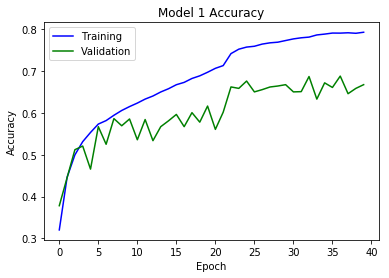

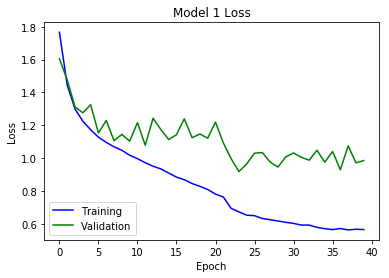

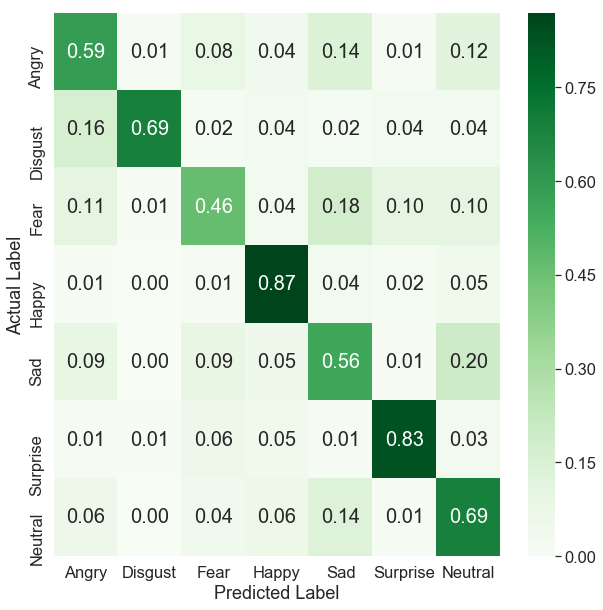

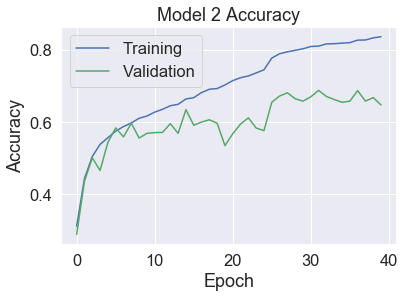

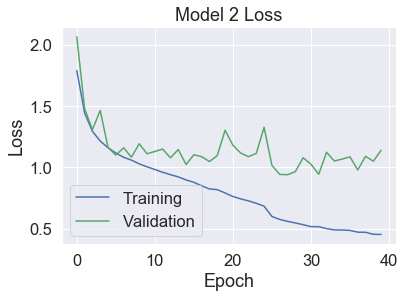

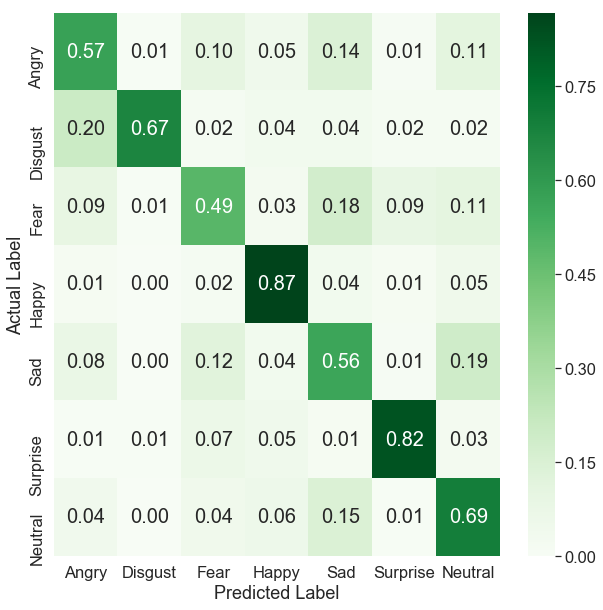

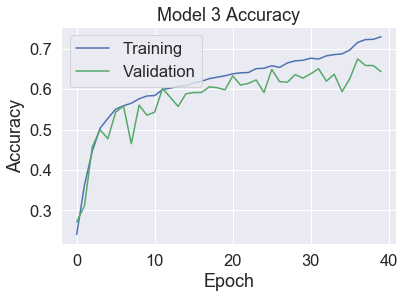

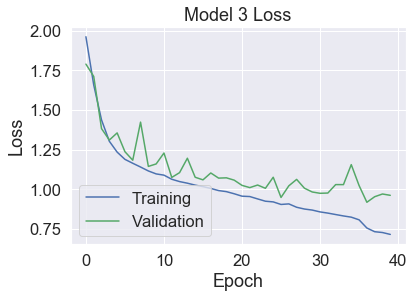

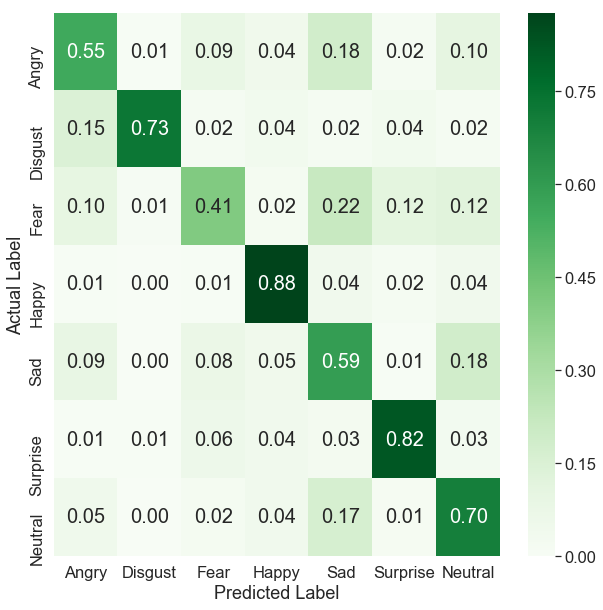

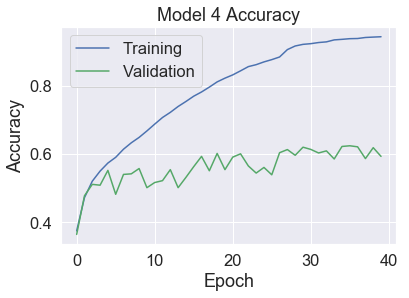

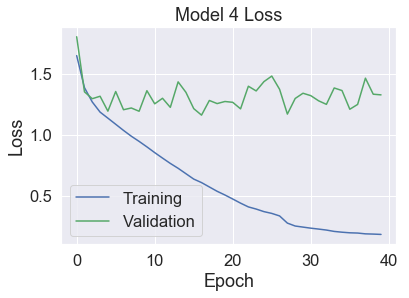

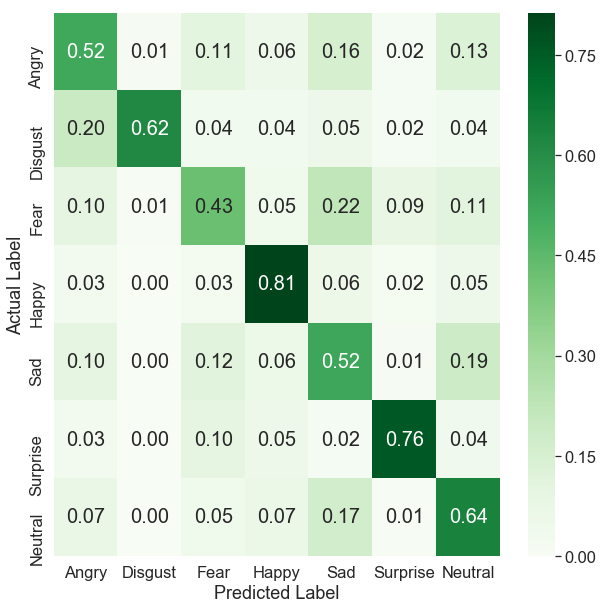

In [11]:
# Model 1 Stats
plt.figure()
plt.plot(history1.history['acc'], color='b', label='Training')
plt.plot(history1.history['val_acc'], color='g', label='Validation')
plt.title('Model 1 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.plot(history1.history['loss'], color='b', label='Training')
plt.plot(history1.history['val_loss'], color='g', label='Validation')
plt.title('Model 1 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower left')
plt.show()

y_pred = model1.predict_classes(X_test)
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    cm_norm, annot=True, linewidths=0, square=False, cmap='Greens', 
    yticklabels=emotion_labels, xticklabels=emotion_labels, 
    vmin=0, vmax=np.max(cm_norm), fmt='.2f', 
    annot_kws={'size': 20}
)
ax.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.show()


# Model 2 Stats
plt.figure()
plt.plot(history2.history['acc'], color='b', label='Training')
plt.plot(history2.history['val_acc'], color='g', label='Validation')
plt.title('Model 2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.plot(history2.history['loss'], color='b', label='Training')
plt.plot(history2.history['val_loss'], color='g', label='Validation')
plt.title('Model 2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower left')
plt.show()

y_pred = model2.predict_classes(X_test)
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    cm_norm, annot=True, linewidths=0, square=False, cmap='Greens', 
    yticklabels=emotion_labels, xticklabels=emotion_labels, 
    vmin=0, vmax=np.max(cm_norm), fmt='.2f', 
    annot_kws={'size': 20}
)
ax.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.show()


# Model 3 Stats
plt.figure()
plt.plot(history3.history['acc'], color='b', label='Training')
plt.plot(history3.history['val_acc'], color='g', label='Validation')
plt.title('Model 3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.plot(history3.history['loss'], color='b', label='Training')
plt.plot(history3.history['val_loss'], color='g', label='Validation')
plt.title('Model 3 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower left')
plt.show()

y_pred = model3.predict_classes(X_test)
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    cm_norm, annot=True, linewidths=0, square=False, cmap='Greens', 
    yticklabels=emotion_labels, xticklabels=emotion_labels, 
    vmin=0, vmax=np.max(cm_norm), fmt='.2f', 
    annot_kws={'size': 20}
)
ax.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.show()


# Model 4 Stats
plt.figure()
plt.plot(history4.history['acc'], color='b', label='Training')
plt.plot(history4.history['val_acc'], color='g', label='Validation')
plt.title('Model 4 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.plot(history4.history['loss'], color='b', label='Training')
plt.plot(history4.history['val_loss'], color='g', label='Validation')
plt.title('Model 4 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower left')
plt.show()

y_pred = model4.predict_classes(X_test)
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    cm_norm, annot=True, linewidths=0, square=False, cmap='Greens', 
    yticklabels=emotion_labels, xticklabels=emotion_labels, 
    vmin=0, vmax=np.max(cm_norm), fmt='.2f', 
    annot_kws={'size': 20}
)
ax.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.show()

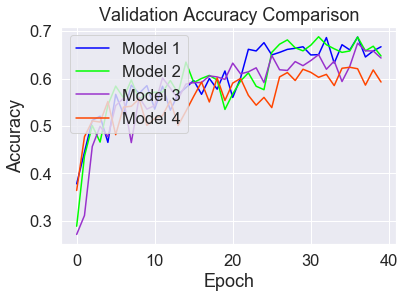

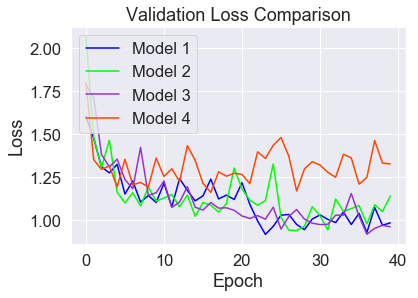

In [12]:
# Validation Comparison
fig1 = plt.figure()
plt.plot(history1.history['val_acc'], color='#0000FF', label='Model 1')
plt.plot(history2.history['val_acc'], color='#00FF00', label='Model 2')
plt.plot(history3.history['val_acc'], color='#9932CC', label='Model 3')
plt.plot(history4.history['val_acc'], color='#FF4500', label='Model 4')
plt.title('Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show() 

# Loss Comparison
fig1 = plt.figure()
plt.plot(history1.history['val_loss'], color='#0000FF', label='Model 1')
plt.plot(history2.history['val_loss'], color='#00FF00', label='Model 2')
plt.plot(history3.history['val_loss'], color='#9932CC', label='Model 3')
plt.plot(history4.history['val_loss'], color='#FF4500', label='Model 4')
plt.title('Validation Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show() 